## Notebook 8: Solution: Model Evaluation 

In this notebook, we get a feel for the general handling of the code. We experiment with different approaches to generate duplicate or similar images.

We also examine the influence of the selected ML model on the interactions between the input features and on our target.  

## Step 1: Imports

More libraries can be implemented here if needed.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.utils import resample

import shap
import xgboost as xgb


## Step 2: Data preparation

We load our data and select the features we need. 
We want the full feature set for the following analysis, so we swap the commantation.   
Our target is called "Fitted Material condition" in the dataset. It is the shape deviation in the observed milling process. 

In [23]:
# path to csv file
data = pd.read_csv("use_case_modelevaluation.csv.gz", compression="gzip")

# desired plot-size in mm
width_mm = 300  # A4-width
height_mm = 90  # A4-height

# conversion to inches
width_inch = width_mm / 25.4
height_inch = height_mm / 25.4


# determine features and target
# all features
features_ = ["X-Position", "Y-Position", "side", "Vorschubkraft", "Vorschubnormalkraft", "VorschubCurrent", "VorschubnormalCurrent", "CSV Connector-INORM",
            "cfc_1","cfc_2","cfc_3", "X", "Y", "Z", "POSF_X", "POSF_Y", "POSF_Z", "Dexelcore: Mean-Dexel-Q_w", "Dexelcore: Mean-Dexel-V_cut", 
            "Dexelcore: X-Dexel-SpanungsquerschnittHuellkoerper","Dexelcore: Y-Dexel-SpanungsquerschnittHuellkoerper", "Dexelcore: Z-Dexel-SpanungsquerschnittHuellkoerper", "Volumen_kumuliert",
            "Phi_1","Phi_2","rho_min","rho_max","distance_angle_calc" ]

# selected features
# features_=["CSV Connector-INORM", "POSF_X", "POSF_Y", "POSF_Z", "Volumen_kumuliert", "Phi_1", "Phi_2"]

target = "Fitted Material condition"
data_sample = data[data["Block"] == 3] # Optional: all data can also be used

# preparing feature and target data
X = data_sample[features_]
y = data_sample[target]

## Step 3: Pearson-Correlation & Spearman-Correlation

We start with a little analysis of the data. The Pearson correlation examines **linear** relationships, while Spearman recognizes **monotonic nonlinear** correlations.

---

### Exercise: 
Get the figure of the correlation matrix for each feature set. 
Either you change the comment functions or you supplement the code with additional plots.

---

### Interpretation: 
Strongly coloured cells are highly correlated with each other. There is a distinction between positive (red) and negative (blue) correlation. The less strongly coloured areas have a lower correlation with each other.

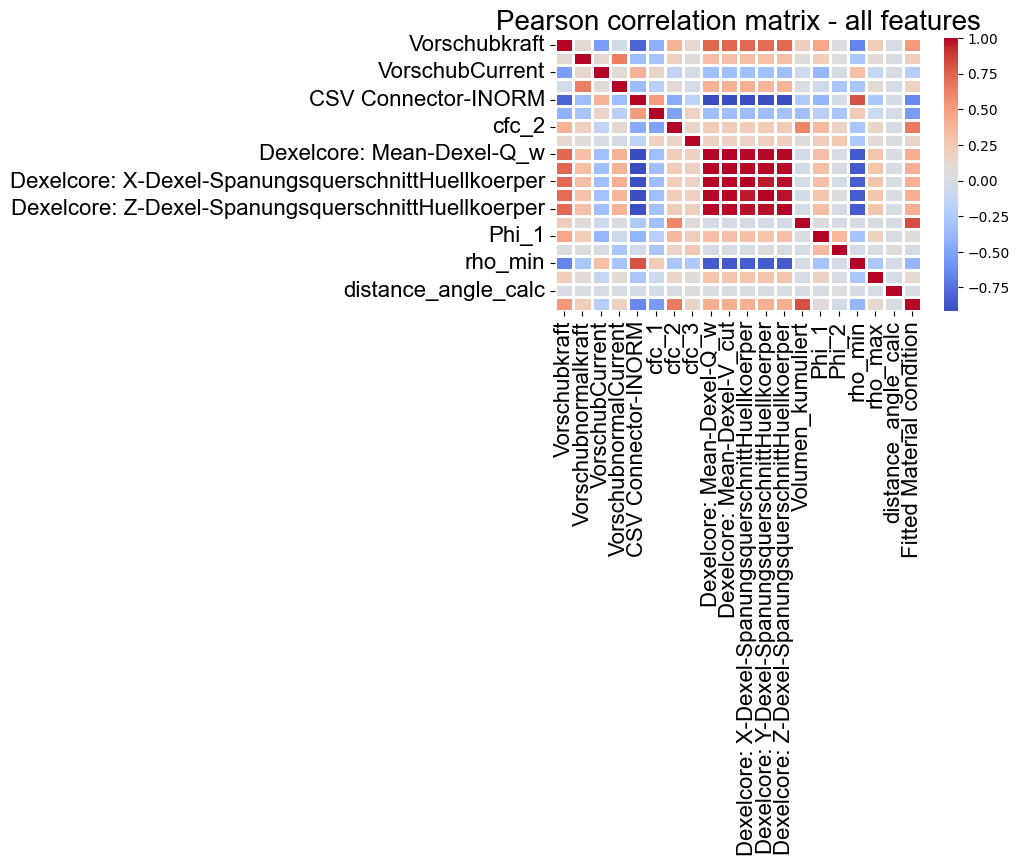

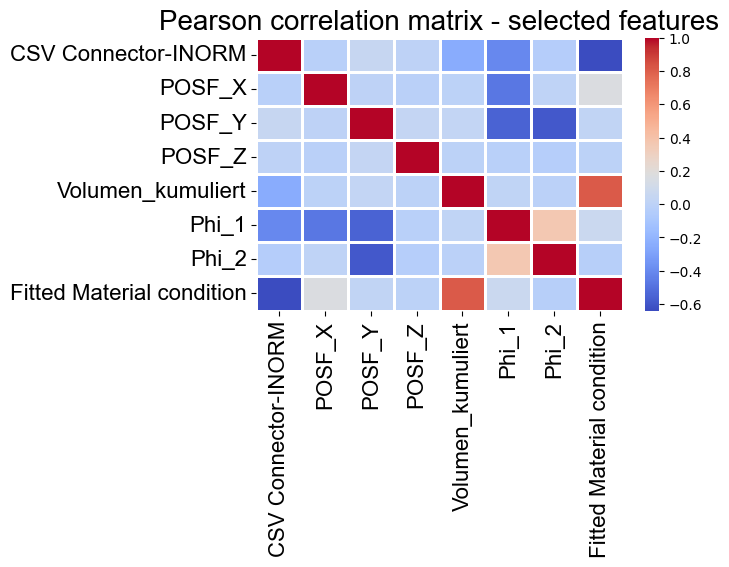

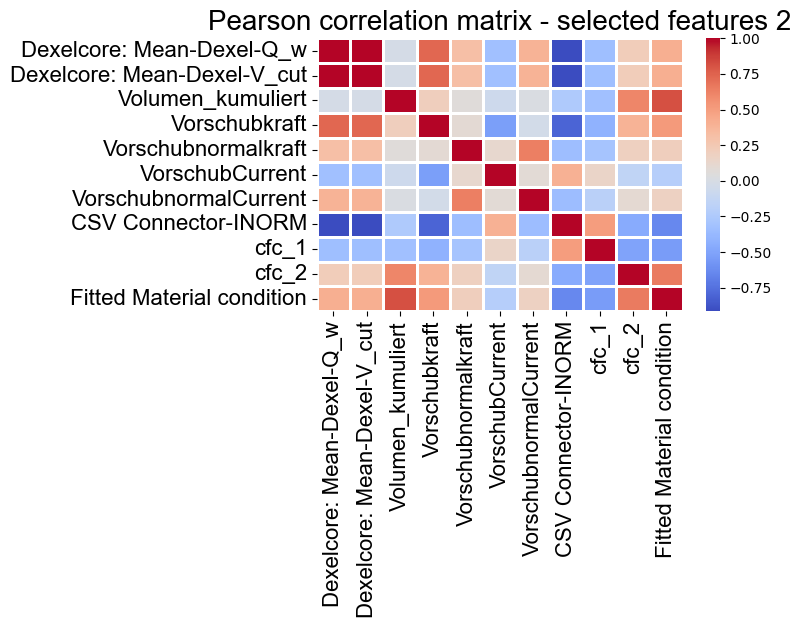

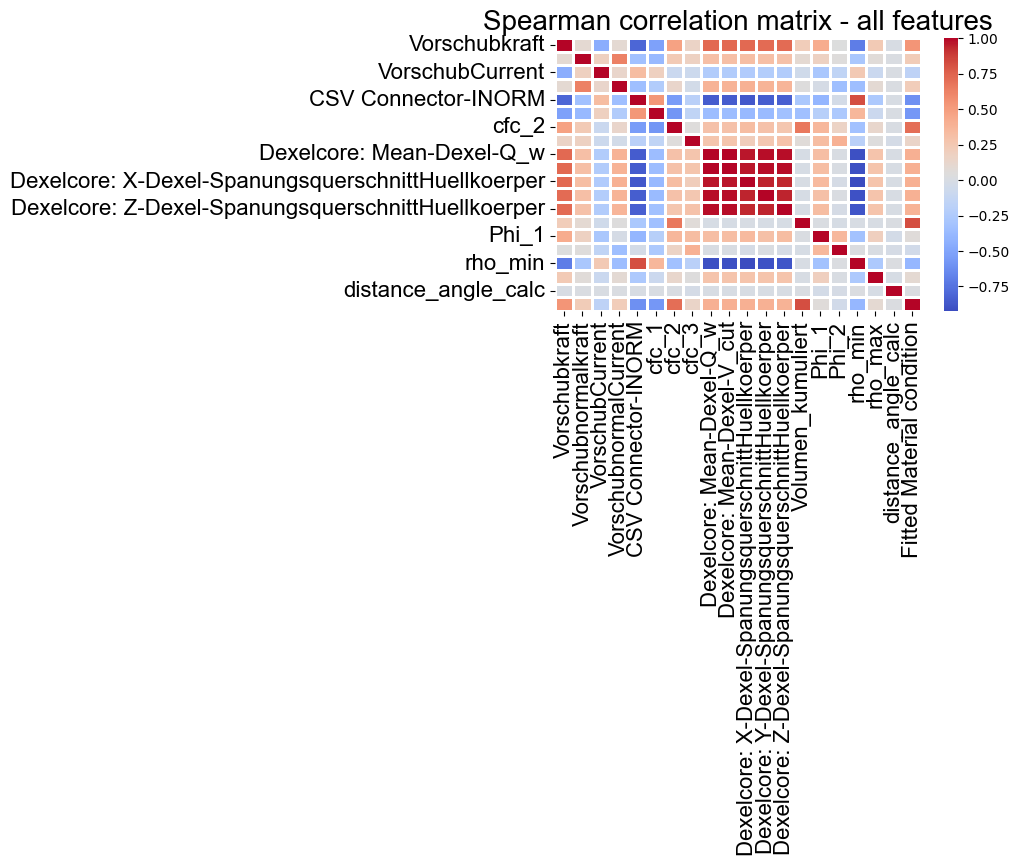

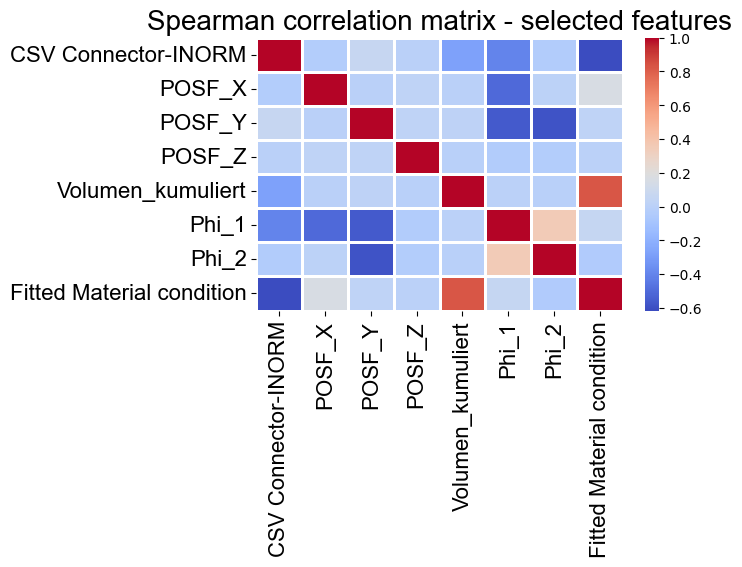

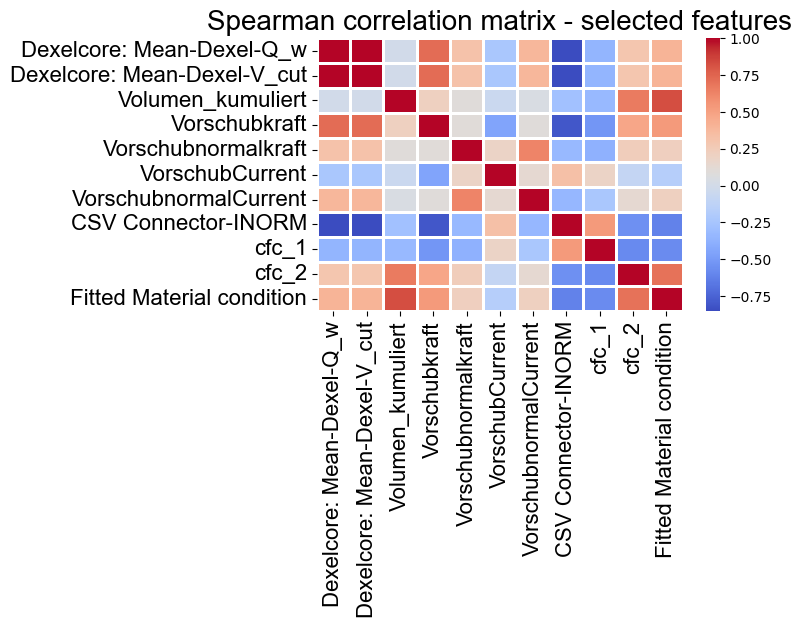

In [7]:
# ----------------
# Pearson
# ----------------

# all features
pearson_corr = data_sample[["Vorschubkraft", "Vorschubnormalkraft", "VorschubCurrent", "VorschubnormalCurrent", "CSV Connector-INORM","cfc_1","cfc_2","cfc_3",
             "Dexelcore: Mean-Dexel-Q_w", "Dexelcore: Mean-Dexel-V_cut", "Dexelcore: X-Dexel-SpanungsquerschnittHuellkoerper","Dexelcore: Y-Dexel-SpanungsquerschnittHuellkoerper", "Dexelcore: Z-Dexel-SpanungsquerschnittHuellkoerper", "Volumen_kumuliert",
             "Phi_1","Phi_2","rho_min","rho_max","distance_angle_calc", "Fitted Material condition" ]].corr(method='pearson')


# Pearson correlation matrix 
plt.figure(figsize=(width_inch/2, height_inch))
sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', linewidths=1)
plt.title('Pearson correlation matrix - all features', fontsize=20, fontname='Arial')
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


# selected features
pearson_corr = data_sample[["CSV Connector-INORM", "POSF_X", "POSF_Y", "POSF_Z", "Volumen_kumuliert", "Phi_1", "Phi_2", "Fitted Material condition"]].corr(method='pearson')

# Pearson correlation matrix 
plt.figure(figsize=(width_inch/2, height_inch))
sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', linewidths=1)
plt.title('Pearson correlation matrix - selected features', fontsize=20, fontname='Arial')
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


# other selected features
pearson_corr = data_sample[["Dexelcore: Mean-Dexel-Q_w", "Dexelcore: Mean-Dexel-V_cut", "Volumen_kumuliert", "Vorschubkraft", "Vorschubnormalkraft", "VorschubCurrent", "VorschubnormalCurrent", "CSV Connector-INORM", "cfc_1", "cfc_2", "Fitted Material condition" ]].corr(method='pearson')

# Pearson correlation matrix 
plt.figure(figsize=(width_inch/2, height_inch))
sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', linewidths=1)
plt.title('Pearson correlation matrix - selected features 2', fontsize=20, fontname='Arial')
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()



# -------------------------
# Spearman
# -------------------------

# all features
spearman_corr = data_sample[["Vorschubkraft", "Vorschubnormalkraft", "VorschubCurrent", "VorschubnormalCurrent", "CSV Connector-INORM","cfc_1","cfc_2","cfc_3",
             "Dexelcore: Mean-Dexel-Q_w", "Dexelcore: Mean-Dexel-V_cut", "Dexelcore: X-Dexel-SpanungsquerschnittHuellkoerper","Dexelcore: Y-Dexel-SpanungsquerschnittHuellkoerper", "Dexelcore: Z-Dexel-SpanungsquerschnittHuellkoerper", "Volumen_kumuliert",
             "Phi_1","Phi_2","rho_min","rho_max","distance_angle_calc", "Fitted Material condition" ]].corr(method='spearman')


# Spearman-Korrelationsmatrix plotten
plt.figure(figsize=(width_inch/2, height_inch))
sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', linewidths=1)
plt.title('Spearman correlation matrix - all features', fontsize=20, fontname='Arial')
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


# selected features
spearman_corr = data_sample[["CSV Connector-INORM", "POSF_X", "POSF_Y", "POSF_Z", "Volumen_kumuliert", "Phi_1", "Phi_2", "Fitted Material condition"]].corr(method='spearman')

# Spearman-Korrelationsmatrix plotten
plt.figure(figsize=(width_inch/2, height_inch))
sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', linewidths=1)
plt.title('Spearman correlation matrix - selected features', fontsize=20, fontname='Arial')
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


# other selected features
spearman_corr = data_sample[["Dexelcore: Mean-Dexel-Q_w", "Dexelcore: Mean-Dexel-V_cut", "Volumen_kumuliert", "Vorschubkraft", "Vorschubnormalkraft", "VorschubCurrent", "VorschubnormalCurrent", "CSV Connector-INORM", "cfc_1", "cfc_2", "Fitted Material condition" ]].corr(method='spearman')

# Spearman-Korrelationsmatrix plotten
plt.figure(figsize=(width_inch/2, height_inch))
sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', linewidths=1)
plt.title('Spearman correlation matrix - selected features', fontsize=20, fontname='Arial')
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


### Results Step 3: 
The correlation matrices show both the correlation with the target and the correlations between the features.   
Overall, Pearson and Spearman show very similar results:    
The cumulative volume ("Volumen_kumuliert") shows the highest positive correlation with the target ("Fitted Material condition"), followed by cfc_2, feed force ("Vorschubkraft"), and the Dexelcore features from the simulation. The spindle current ("CSV Connector-INORM") and cfc_1 show a clear negative correlation with the target. 

---

## Step 4: Residual-Plot

Residuals are the difference between the actual and the predicted values.   
The residual plot is used to check how well a regression model fits the data.

---

### Exercise: 
Currently, an XGBoot regression is being examined using the residual plot. Replace the XGBoost model with a random forest and compare the results. 

---

### Interpretation and Results
A well-fitting model for the data is characterized by the fact that the residuals in this plot scatter close to the zero line. 

Try it out: If you use the well-tuned Random Forest model from Notebook 4, the results in the residual plot are better than with XGBoost.   
A less deep Random Forest model has a significantly greater dispersion. However, the tuned model is too complex for the SHAP analysis in the next section.

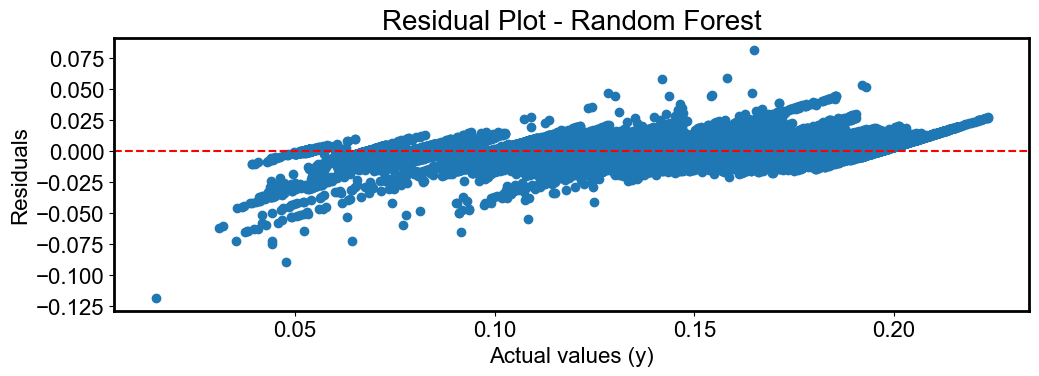

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

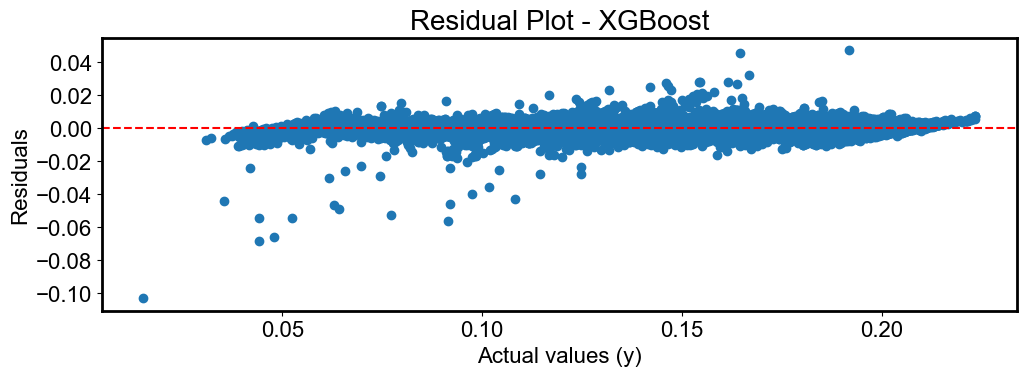

In [ ]:
# -------------------
# Random Forest Regression
# -------------------
""" It depends on the Random Forest, but this step can take up to 3 minutes."""

# # Best hyperparameters from previous tuning
# best_params = {
#     'n_estimators': 239,
#     'max_depth': 59,
#     'min_samples_split': 2,
#     'min_samples_leaf': 1,
#     'max_features': 'sqrt'
# }

# model = RandomForestRegressor(
#     n_estimators=best_params['n_estimators'],
#     min_samples_split=best_params['min_samples_split'],
#     min_samples_leaf=best_params['min_samples_leaf'],
#     max_features=best_params['max_features'],
#     max_depth=best_params['max_depth'],
#     random_state=42,
#     n_jobs=-1
# )


model = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    max_features=0.8,   
    bootstrap=True      
)

model.fit(X, y)

# prediction
y_pred = model.predict(X)

# calculate residuals
residuals = y - y_pred


# Plot der Residuen

plt.figure(figsize=(width_inch, height_inch))
plt.scatter(y, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot - Random Forest', fontsize=20, fontname='Arial')
plt.xlabel('Actual values (y)', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()



# -------------------
# XGBoost Regression 
# -------------------

model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

model.fit(X, y)

# prediction
y_pred = model.predict(X)

# calculate residuals
residuals = y - y_pred


# Plot der Residuen

plt.figure(figsize=(width_inch, height_inch))
plt.scatter(y, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot - XGBoost', fontsize=20, fontname='Arial')
plt.xlabel('Actual values (y)', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


## Step 5: SHAP Analysis (SHapley Additive exPlanations)
SHAP is a game-theoretic approach to explain the output of any machine learning model.      
The core idea of SHAP is based on Shapley values from cooperative game theory. SHAP values quantify how much each feature contribute to the difference between the actual prediction and the average prediction for all instances. 

---

### Exercise: 
Replace XGBoost with Random Forest as in Step 4 and compare the results. Run all SHAP plots with the new ML model. 

--- 
### Additional Information:
We saw in the residual plot that the random forest from Notebook 4 fits the data well. However, SHAP is very computationally intensive, so we have to resort to a less complex tree structure here. 

In [9]:
# -------------------
# Random Forest Regression
# -------------------
""" this will take about 3 minutes """

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    max_features=0.8,   # ungefähr wie colsample_bytree
    bootstrap=True      # ungefähr wie subsample (Stichproben mit Zurücklegen)
    # learning_rate und objective gibt es hier nicht
)

model.fit(X, y)


RandomForestRegressor(max_depth=5, max_features=0.8, n_estimators=300)

In [10]:
# --------------------
# calculate SHAP values
# --------------------
explainer = shap.TreeExplainer(model)
shap_values_rf = explainer(X, check_additivity=False)  # shape (61299, 1)

In [11]:
# Random Forest
shap_values_rf.base_values = shap_values_rf.base_values.reshape(-1) # shape (61299, )

In [12]:
# Index of the prediction to be plotted
i = 0

# raw data from shap_values_rf
vals_all  = shap_values_rf.values        # (61299, 28)
base_all  = shap_values_rf.base_values   # (61299, 1)
data_all  = shap_values_rf.data          # = X

# make base_value for the i-th row a scalar
base_i = float(np.array(base_all[i]).reshape(-1)[0])

# new explanation object just for this row
exp_i = shap.Explanation(
    values      = np.array(vals_all[i], dtype=float),  # (28,)
    base_values = base_i,                              # Scalar
    data        = np.array(data_all[i], dtype=float),  # (28,)
    feature_names = getattr(shap_values_rf, "feature_names", getattr(X, "columns", None))
)


---

In [13]:
# --------------------
# XGBoost Regression
# --------------------
""" this will take about 8-9 min """

model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

model.fit(X, y)

# --------------------
# calculate SHAP values
# --------------------
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
100%|===================| 61200/61299 [06:37<00:00]        

---

### Waterfall Plot

The waterfall plot shows the local influence of features to a single prediction point.  
Hints for the interpretation: 
- The value of the feature in the prediction under consideration is highlighted in gray to the left of the feature.
- The entry in the waterfall plot depends on the SHAP value. This indicates the influence on the prediction.
- The zero line is the predicted value.

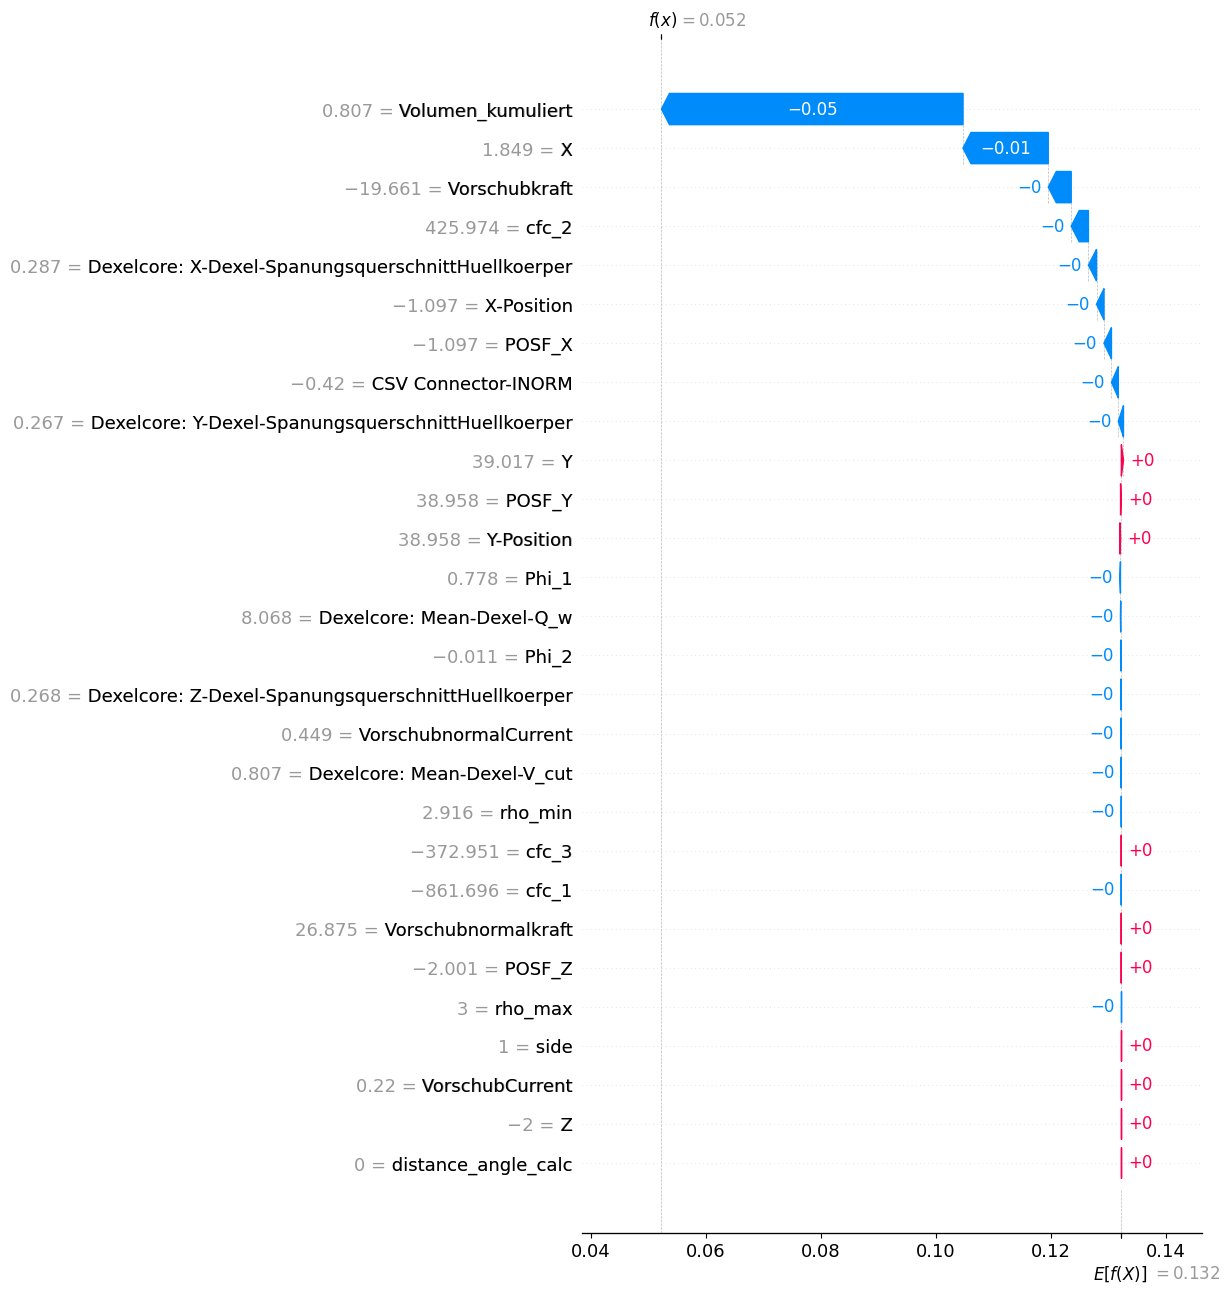

In [14]:
# --------------------
# Waterfall plot 
# --------------------
""" local influence of features for a single point """

# Random Forest
# Example: the first sample from the data set
plt.figure() 
shap.plots.waterfall(exp_i, max_display=28)
plt.show()

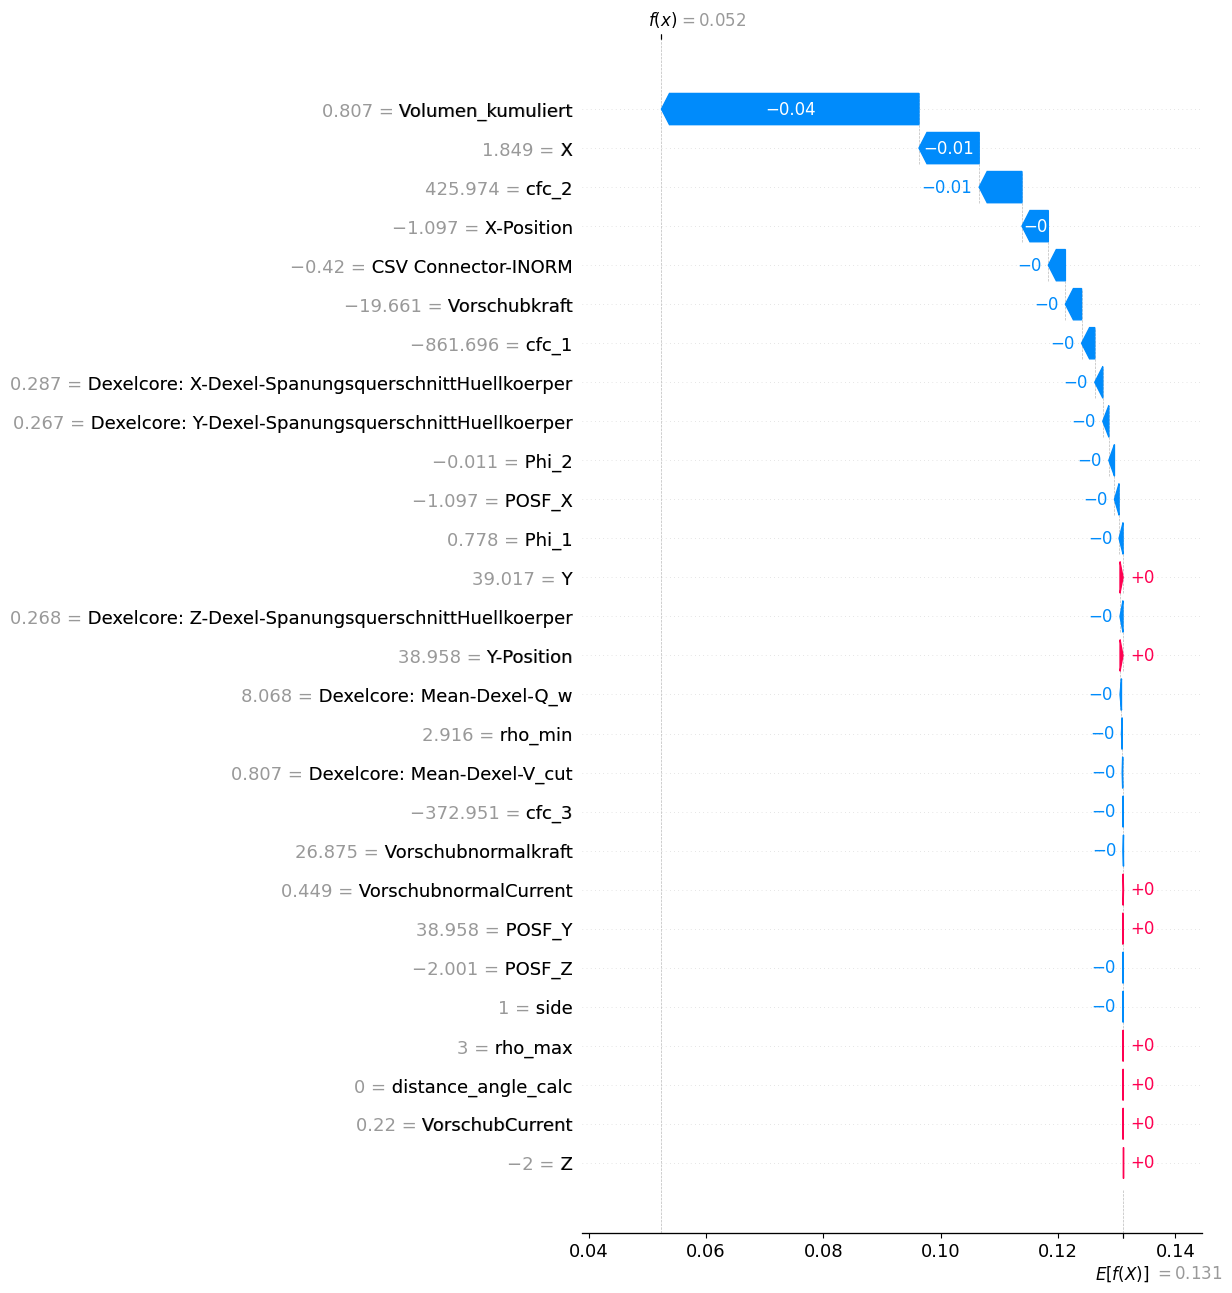

In [15]:
# --------------------
# Waterfall plot 
# --------------------

# XGBoost
# Example: the first sample from the data set
plt.figure()
shap.plots.waterfall(shap_values[0], max_display=28) 
plt.show()

---

### Feature Importance Plot
The feature importance plot considers all predictions and calculates a global shap value for each feature.  
The averaged SHAP value thus indicates the global or averaged influence of a feature.

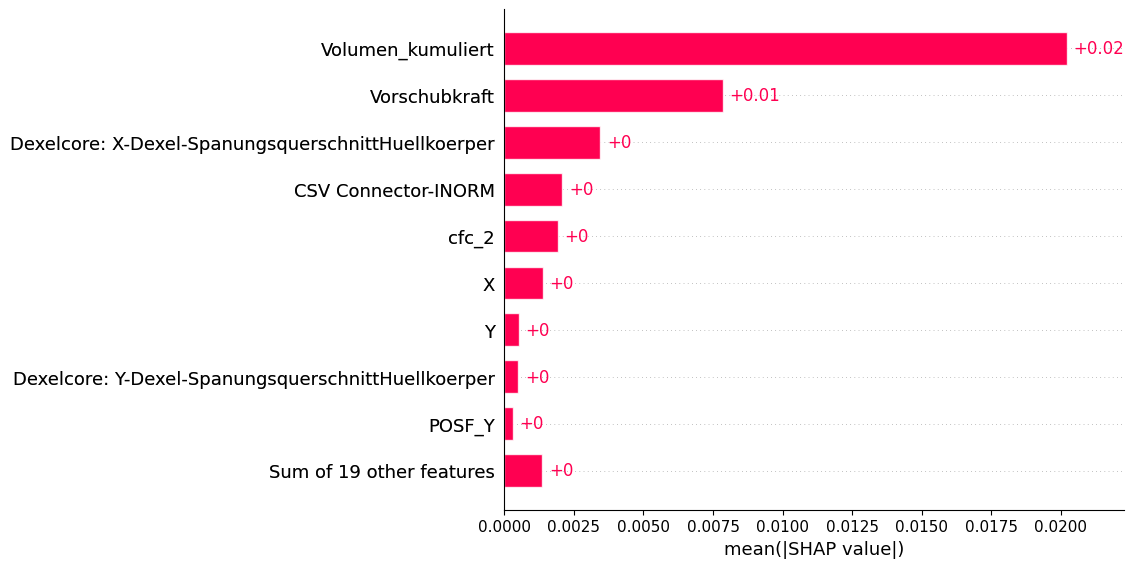

In [16]:
# Feature Importance
""" average absolute SHAP value per feature (global importance) """

# Random Forest
shap.plots.bar(shap_values_rf, max_display=10)        
plt.show()

The Random Forest also has the option of directly incorporating feature importance itself. The model's own values are shown here:

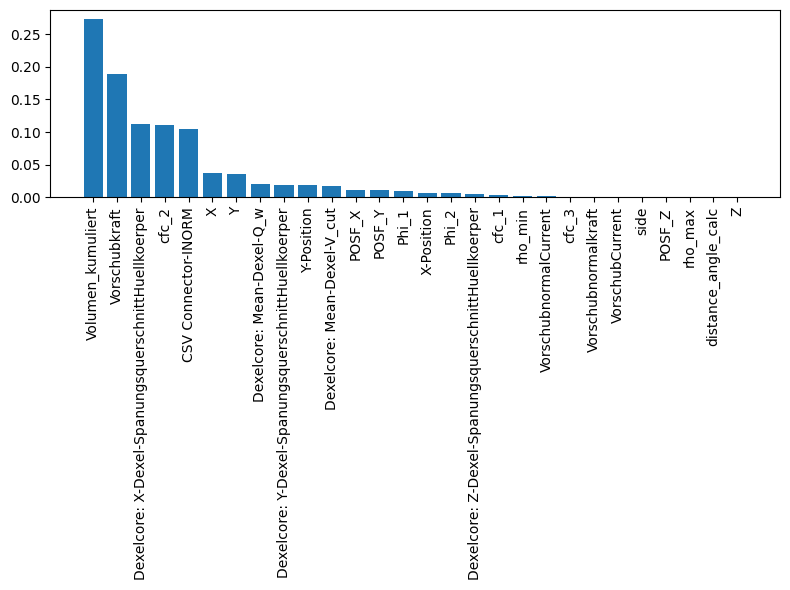

In [21]:
# Random Forest 

importances = model.feature_importances_
feature_names = getattr(X, "columns", np.arange(len(importances)))

idx = np.argsort(importances)[::-1]  # sortiert absteigend

plt.figure(figsize=(8, 6))
plt.bar(range(len(importances)), importances[idx])
plt.xticks(range(len(importances)), np.array(feature_names)[idx], rotation=90)
plt.tight_layout()
plt.show()

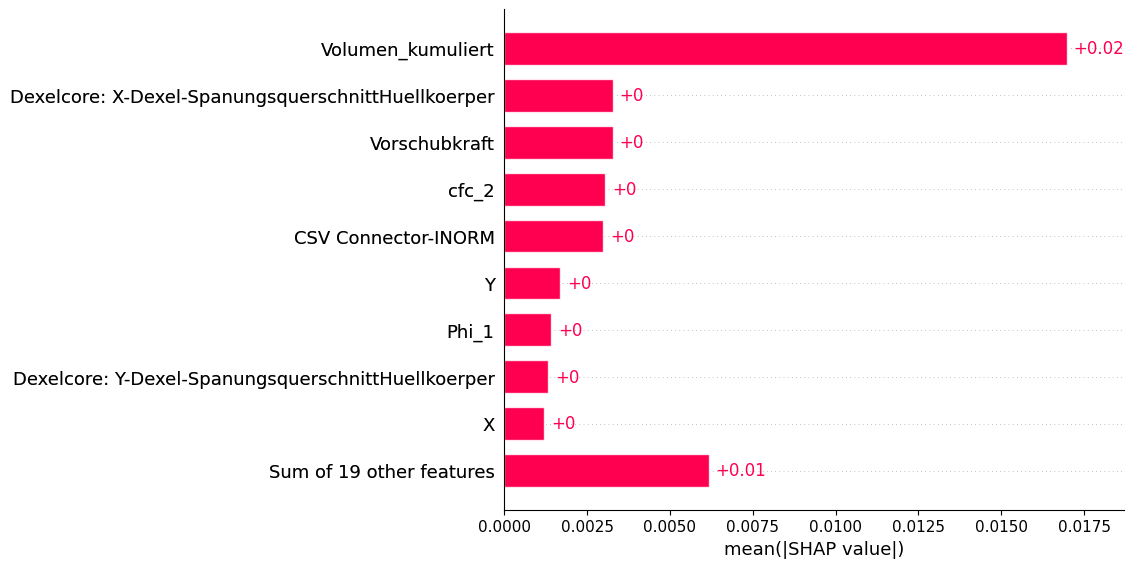

In [17]:
# Feature Importance
""" average absolute SHAP value per feature (global importance) """

# XGBoost
shap.plots.bar(shap_values)        
plt.show()

---

### Beeswarm Plot
The Beeswarm plot shows each local SHAP value for each feature. The color coding indicates whether the actual value of a feature is high or low, and the SHAP value, i.e., the influence on the forecast, can be read on the x-axis.    
Correlations and shifts can be identified. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


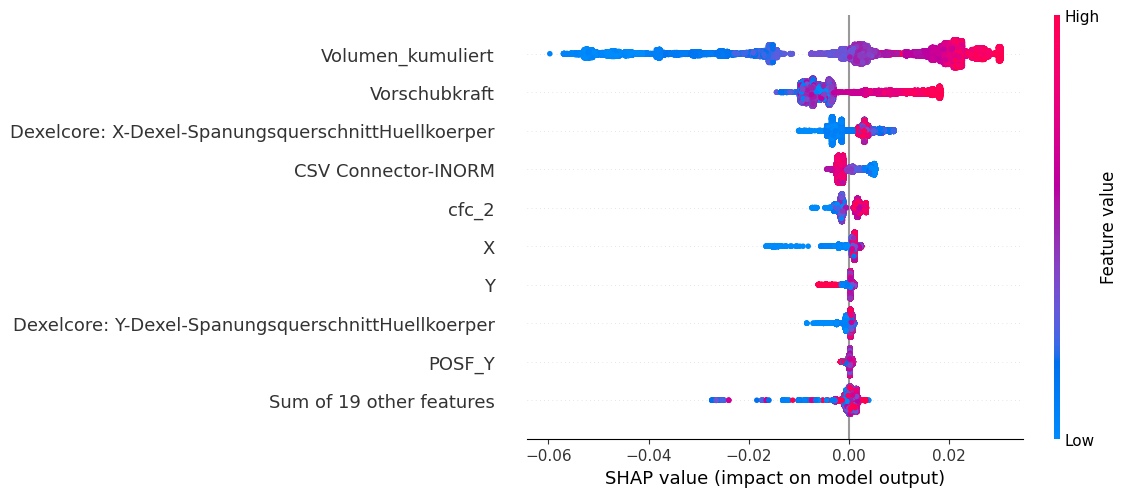

In [18]:
# Beeswarm Plot
""" shows in which direction (positive/negative) a feature typically has an effect and how strongly it varies. """

# Random Forest
shap.plots.beeswarm(shap_values_rf, max_display=10)   
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


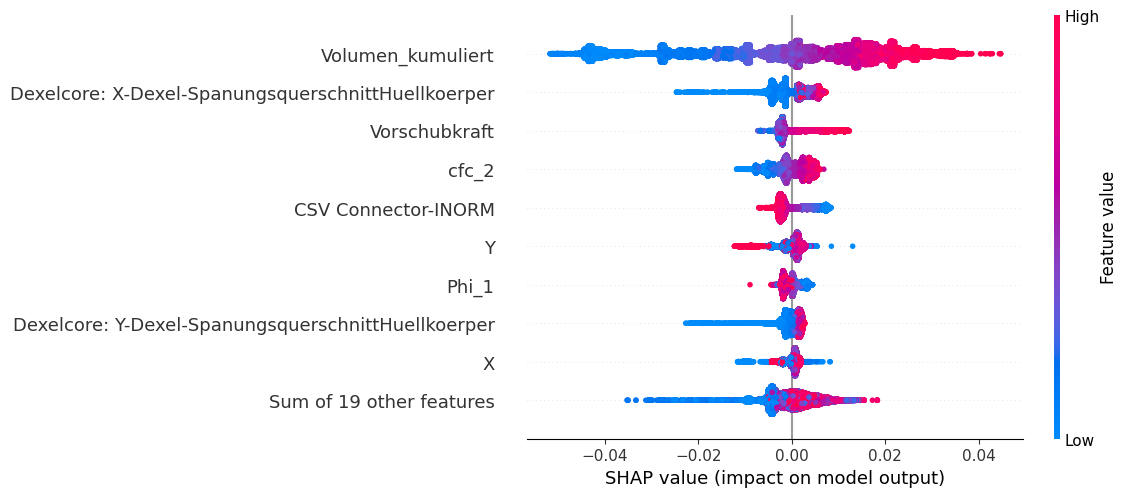

In [19]:
# Beeswarm Plot
""" shows in which direction (positive/negative) a feature typically has an effect and how strongly it varies. """

# XGBoost
shap.plots.beeswarm(shap_values)   
plt.show()

## Results and Interpretation

### Waterfall Plot 
When comparing the waterfall plots of the two ML models, the first prediction is examined in each case. It is noticeable that the top 5 local influence features **differ depending on the model**. 
The strongest influencing factor in both models is the cumulative volume (“Volumen_kumuliert”), and the second feature is also the same in both models (“X”). 
In Random Forest, “feed force” ("Vorschubkraft") is in the top 3 position, while in XGBoost it just misses the top 5. This shows that the local significance of an input feature for a prediction depends on the selected ML model. 


The feature importance plot can be used to check whether the local fluctuations between the ML models also influence the global feature importance. 

---
### Feature Importance Plot
The feature importance plot **considers the mean values of the Shap values**. Looking at the random forest, the top three influencing factors can be clearly distinguished. Cumulative volume, feed force, and chip cross-section envelope in the X direction, with the third feature coming from a simulation. The global feature importance in XGBoost distinguishes the cumulative volume more clearly. The following four places are very close together. 
However, they contain the same top 5 features as in the random forest. 

**The local consideration of the features was therefore not reflected in the global feature importance.** 

The random forest also has the option of outputting a **model-internal feature importance**. The top three distinctions are similar to the SHAP evaluations for the random forest, and the other features in the top five also fit in with the picture painted by the two SHAP analyses. 

---
### Beeswarm Plot
The beeswarm plot is generally somewhat more difficult to interpret because it contains more information. It shows each individual SHAP value of a feature (see x-axis), including information about whether the real value of the feature is high or low. 

There are slight differences between the two models: 
In both cases, the greatest dispersion in the SHAP values is in the cumulative volume, even though the values in the Random Forest show a gap. The drift in the feed force is significantly different. In Random Forest, there are many clustered values on the one hand, while the high values also tend to have a high SHAP value. In XGBoost, there tend to be two clustered spots of values and a tendency for low values to also lead to low SHAP values. 